# Janssen AMES Dataset Analysis


Import required packages

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

%matplotlib inline

Setup paths

In [2]:
data_path = "datasets"

In [3]:
if not os.path.isdir(data_path):
    os.mkdir(data_path)
    # load data from the google drive

In [4]:
def load_npz(path, file_name):
    with np.load(os.path.join(data_path, file_name), mmap_mode='rb', fix_imports=True) as file:
        if file is None:
            print("Failed to load {} file".format(file_name))
        else:
            print("{} contains the following files: {}".format(file_name, file.files))
            data_arrays = []
            for _name in file.files:
                data = file[_name]
                data_arrays.append(data)
                print(" - {} contains the data of the following shape: {}, type: {}, min: {}, max: {}".format(_name, data.shape, data.dtype, data.min(), data.max()))
    return data_arrays

In [5]:
ames_mrgne = load_npz(data_path, "ames_mrgne.npz")
ames_mrgnf = load_npz(data_path, "ames_mrgnf.npz")
ames_rdkit2d = load_npz(data_path, "ames_rdkit2d.npz")

ames_mrgne = ames_mrgne[0]
ames_mrgnf = ames_mrgnf[0]
ames_rdkit2d = ames_rdkit2d[0]

with open(os.path.join(data_path, "ames_data.csv"), "r") as file:
    ames_data = pd.read_csv(file)
    if ames_data is not None:
        _label_name = ames_data.columns[-1]
        print("ames_data.csv contains the following fields: {}".format(ames_data.columns))
        print(" - {} column contains the following data: n records: {}, type: {}, min: {}, max: {}".format(
            _label_name, ames_data[_label_name].size, ames_data[_label_name].dtype, ames_data[_label_name].min(), ames_data[_label_name].max()))
        
data = ames_mrgne.astype(np.float)
labels = ames_data['ames'].astype(np.float)

ames_mrgne.npz contains the following files: ['arr_0']
 - arr_0 contains the data of the following shape: (4324, 2048), type: int64, min: 0, max: 34
ames_mrgnf.npz contains the following files: ['arr_0']
 - arr_0 contains the data of the following shape: (4324, 4096), type: int64, min: 0, max: 1
ames_rdkit2d.npz contains the following files: ['arr_0']
 - arr_0 contains the data of the following shape: (4324, 200), type: float64, min: nan, max: nan
ames_data.csv contains the following fields: Index(['smiles', 'ames'], dtype='object')
 - ames column contains the following data: n records: 4324, type: int64, min: 0, max: 1


### Data analysis


#### Validate class balance

If the data is highly imbalanced, the model is likely to focus on the dominant class and limit the accuracy of the model.

Number of samples:
Class 0/Flase: 1931
Class 1/True: 2393


Text(0, 0.5, 'Number of samples')

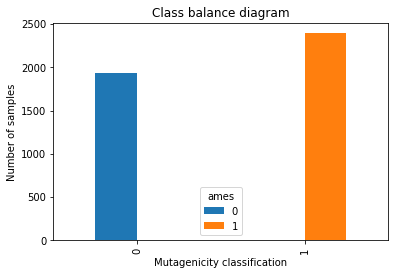

In [6]:
print("Number of samples:\nClass 0/Flase: {}\nClass 1/True: {}".format(sum(labels==0), sum(labels==1)))
pd.crosstab(ames_data['ames'], ames_data['ames']).plot(kind='bar')
plt.title('Class balance diagram')
plt.xlabel('Mutagenicity classification')
plt.ylabel('Number of samples')

The diagram above indicates that the provided dataset is fairly balanced. Thus it provides a good foundation for training a model. No oversampling/subsampling is required.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer

# suppress future warnings outputed by sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

### Choose and train a model

In order to establish a base-line, fit a Logistic Regression. Sklearn Logistic regression is implemented with L2 regularization of model weights. The strength of the regularization is controlled with a hyperparameter "C". Use GridSearch to find optimal values of "C" hyperparameter.

In [8]:
parameters = {'C': [10**p for p in range(-4,4,1)]}
gs = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring=make_scorer(f1_score))
clf = gs.fit(data, labels)
print("Hyperparameter 'C' selected by GridSearch: {}".format(gs.get_params()['estimator__C']))
print("\nThe full list of hyperparameters: \n\n{}".format(clf.get_params()))

Hyperparameter 'C' selected by GridSearch: 1.0

The full list of hyperparameters: 

{'cv': 5, 'error_score': 'raise-deprecating', 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'warn', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'warn', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1

The model performance can vary significantly depending on the data used for training and testing. In order to remove stochasticity from the model evaluation process, I will test the model performance on K-folds.

In [9]:
def eval_classifier(classifier, x, y , k_folds=5):
    precision, recall, accuracy, f1 = [],[],[],[]
    
    # In order to guaranty the consistency between runs, set :parameter random_state to a constant value
    kf = KFold(n_splits=k_folds, random_state=1, shuffle=True)
    for train_index, val_index in kf.split(x):
        x_train, y_train = x[train_index], y[train_index]
        x_val, y_val = x[val_index], y[val_index]

        classifier.fit(x_train, y_train)

        y_true, y_pred = y_val, classifier.predict(x_val)
        
        precision.append(precision_score(y_true, y_pred))
        recall.append(recall_score(y_true, y_pred))
        accuracy.append(accuracy_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))

    print("\nRecall score (TP/(TP+FN)): {:.1f}%".format(100*sum(recall)/k_folds))
    print("Precision score (TP/(TP+FP)): {:.1f}%".format(100*sum(precision)/k_folds))
    print("Accuracy score (TP + TN)/total count: {:.1f}%".format(100*sum(accuracy)/k_folds))
    print("F1 score 2*(precision*recall)/(precision+recall): {:.1f}%".format(100*sum(f1)/k_folds))

In [10]:
eval_classifier(clf, data, labels)


Recall score (TP/(TP+FN)): 83.3%
Precision score (TP/(TP+FP)): 82.9%
Accuracy score (TP + TN)/total count: 81.3%
F1 score 2*(precision*recall)/(precision+recall): 83.1%


Simple logistic regression (baseline) achieved 81.3% accuracy and **83.3% recall**. It is important to note that as the goal of the model is to determin if the molecule is mutagenic, the recall score could be a better metric for judging the model performance.

#### Normalization

Nother factor that can influence Logistic Regression classifier is the scale and variance of the features. If data features have significantly different variance scales, than the model could be dominated by a features with high variance.

In [11]:
std = data.std(axis=0)
print("Feature standrd deviations - min: {}, - max: {}".format(std.min(), std.max()))

Feature standrd deviations - min: 0.04020262019690676, - max: 3.7792394457114016


As expected, features demonstrate a significantly differnt variance (standard deviation). In order to remidiate this problem the data should be normalized by rescalling each feature to the mean of 0 and standard deviation of 1.0:

In [12]:
from sklearn.preprocessing import StandardScaler

z_scaler = StandardScaler()
norm_data = z_scaler.fit_transform(data)
std = norm_data.std(axis=0)
print("Normalized feature standrd deviations - min: {}, - max: {}".format(std.min(), std.max()))

Normalized feature standrd deviations - min: 0.9999999999998722, - max: 1.000000000000149


Compare the performance of Logistic Regression classifier trained on normalized and on raw data.

In [13]:
eval_classifier(clf, norm_data, labels)


Recall score (TP/(TP+FN)): 78.2%
Precision score (TP/(TP+FP)): 83.4%
Accuracy score (TP + TN)/total count: 79.3%
F1 score 2*(precision*recall)/(precision+recall): 80.7%


The model trained on the normalized dataset demostrates a lower accuracy (79.3% vs raw data 81.3%) and recall (78.2% vs. raw data 83.3%), which indicates that the feature scale is an important aspect of the data. Therefore, the future experiments should be performed on the raw data.